#1. Configuración del Ambiente

In [ ]:
!pip install yfinance
import yfinance as yf

from bs4 import BeautifulSoup
import requests

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', figsize = (5, 5))

import time
import datetime as dt
from IPython.display import clear_output

#2.1 Precios Históricos del Bitcoin

In [3]:
#Extracción del histórico de precios del Bitcoin de la última semana en intervalos de 5minutos
df_bitcoin = yf.Ticker("BTC-USD").history(period = "7d", interval = "5m")
df_bitcoin

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-22 00:00:00+00:00,26749.892578,26767.541016,26748.697266,26767.541016,0,0.0,0.0
2023-05-22 00:05:00+00:00,26767.800781,26781.283203,26767.800781,26781.283203,4646912,0.0,0.0
2023-05-22 00:10:00+00:00,26783.734375,26785.113281,26782.589844,26785.113281,5285888,0.0,0.0
2023-05-22 00:15:00+00:00,26783.136719,26783.806641,26768.679688,26768.679688,13245440,0.0,0.0
2023-05-22 00:20:00+00:00,26772.236328,26772.236328,26753.222656,26753.222656,2718720,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-28 23:15:00+00:00,28161.876953,28193.449219,28111.890625,28118.050781,98180096,0.0,0.0
2023-05-28 23:20:00+00:00,28112.871094,28150.638672,28112.871094,28120.023438,126167040,0.0,0.0
2023-05-28 23:25:00+00:00,28118.910156,28119.742188,28102.142578,28115.160156,59147264,0.0,0.0


#2.2 Indicadores de Tendencias

In [22]:
#Web Scraping de la página de tendencias
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}
url = 'https://coinmarketcap.com'
respuesta = requests.get(url, headers=headers)
s = BeautifulSoup(respuesta.content, features='lxml')
respuesta = s.findAll('p', {'class':'sc-4984dd93-0 iqdbQL coin-item-symbol'})

In [23]:
#Calculando posición del Bitcoin
indice=0
for item in respuesta:
  if item.getText()=='BTC':
    break
  indice+=1
print('La posición actual del bitcoin en la tabla es: ', indice)

La posición actual del bitcoin en la tabla es:  0


In [24]:
#Extrayendo el precio del Bitcoin
respuesta = s.findAll('div', {'class':['sc-cadad039-0 clgqXO','sc-cadad039-0 clgqXO fall','sc-cadad039-0 clgqXO rise']})
precio_actual=float(respuesta[indice].getText().replace('$','').replace(',',''))
print('El precio actual del bitcoin es: ', precio_actual)

El precio actual del bitcoin es:  28069.93


In [25]:
#Extrayendo tendencias de 1hr para todas las monedas, salto de 3 en 3 para evitar las tendencias de 24hr y 7dias
lista = []
respuesta = s.findAll('span', {'class':['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']})
for item in respuesta[::3]:
  lista.append(item)
  print(item)

<span class="sc-97d6d2ca-0 bQjSqS"><span class="icon-Caret-down"></span>0.03%</span>
<span class="sc-97d6d2ca-0 cYiHal"><span class="icon-Caret-up"></span>0.27%</span>
<span class="sc-97d6d2ca-0 cYiHal"><span class="icon-Caret-up"></span>0.01%</span>
<span class="sc-97d6d2ca-0 cYiHal"><span class="icon-Caret-up"></span>0.12%</span>
<span class="sc-97d6d2ca-0 cYiHal"><span class="icon-Caret-up"></span>0.01%</span>
<span class="sc-97d6d2ca-0 bQjSqS"><span class="icon-Caret-down"></span>0.34%</span>
<span class="sc-97d6d2ca-0 cYiHal"><span class="icon-Caret-up"></span>0.12%</span>
<span class="sc-97d6d2ca-0 bQjSqS"><span class="icon-Caret-down"></span>0.03%</span>
<span class="sc-97d6d2ca-0 bQjSqS"><span class="icon-Caret-down"></span>0.67%</span>
<span class="sc-97d6d2ca-0 bQjSqS"><span class="icon-Caret-down"></span>0.51%</span>


In [28]:
#Calculando la tendencia exclusivamente del Bitcoin
tendencia = ''
if lista[indice].find('span')['class'][0] == 'icon-Caret-down':
  tendencia = 'baja'
else:
  tendencia = 'alta'
print('La tendencia actual del bitcoin es: ', tendencia)

La tendencia actual del bitcoin es:  baja


#3. Limpieza de datos

In [30]:
#Calcula el precio promedio de la base original
media_original = round(df_bitcoin.Close.mean(),0)

#Elimina Repetidos
df_bitcoin_limpio = df_bitcoin[~df_bitcoin.index.duplicated(keep = 'first')]

#Elimina filas con valor nulo en la columna Close
df_bitcoin_limpio.dropna(subset = ['Close'], inplace=True)

#Filtra operaciones sin volumen
df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio.Volume > 0]

#Actualiza el indice
df_bitcoin_limpio.reset_index(inplace=True)

#Calcula Q1 y Q3
valor = df_bitcoin_limpio['Close']
Q1 = valor.quantile(.25)
Q3 = valor.quantile(.75)

#Selecciona sólo los registros dentro de Q1 y Q3
seleccion = (valor >= Q1) & (valor <= Q3)
df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

#Calcula el precio promedio de la base limpia
media_bitcoin = round(df_bitcoin_limpio.Close.mean(),0)

print('El promedio de precios del Bitcoin antes de la limpieza es: $', media_original)
print('El promedio de precios del Bitcoin después de la limpieza es: $', media_bitcoin)

El promedio de precios del Bitcoin antes de la limpieza es: $ 26799.0
El promedio de precios del Bitcoin después de la limpieza es: $ 26862.0


#4. Tomar decisiones

In [31]:
#Construímos el algoritmo de decisión
if ((precio_actual >= media_bitcoin) and (tendencia == 'baja')):
  algoritmo_decision = 'Vender'
  color = '#dc143c'
elif ((precio_actual < media_bitcoin) and (tendencia == 'alta')):
  algoritmo_decision = 'Comprar'
  color = '#228b22'
else:
  algoritmo_decision = ''
  color = '#000000'
  
print('Precio Promedio Bitcoin: ', media_bitcoin)
print('Precio Actual Bitcoin: ', precio_actual)
print('Tendencia: ', tendencia)
print('Decisión del algoritmo: ', algoritmo_decision)

Precio Promedio Bitcoin:  26862.0
Precio Actual Bitcoin:  28069.93
Tendencia:  baja
Decisión del algoritmo:  Vender


#5. Visualización

Tendencia:  baja


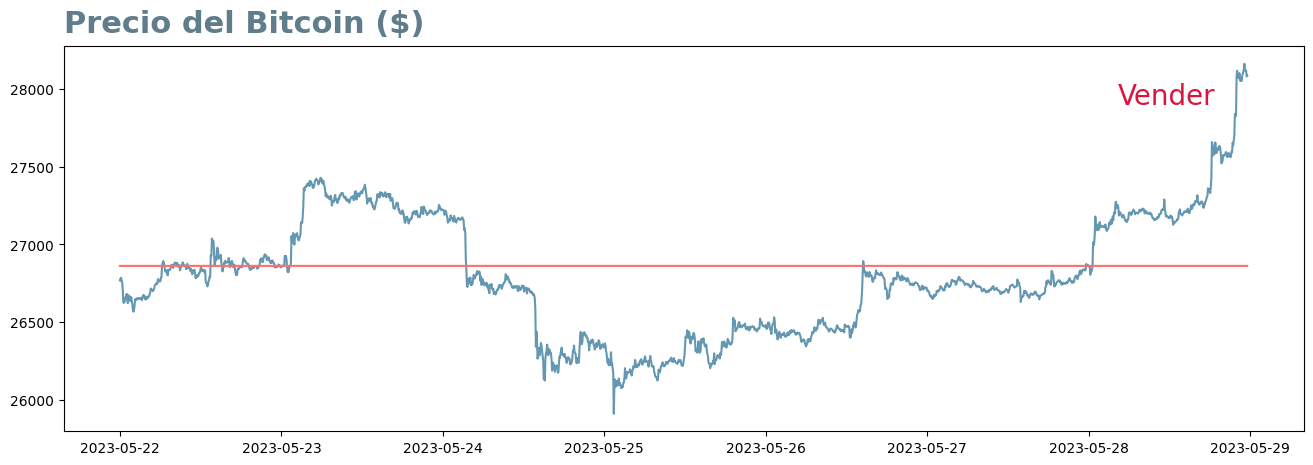

In [34]:
print('Tendencia: ', tendencia)
df_bitcoin['Promedio'] = media_bitcoin
plt.figure(figsize=((16,5)))
plt.title('Precio del Bitcoin ($)', loc='left', fontsize=22, color='#607d8b', fontweight="bold", pad = 10)
plt.plot(df_bitcoin.index, df_bitcoin['Close'], color='#6497b1')
plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], color='#ff6f69')
plt.annotate(algoritmo_decision, xy=(0.85, 0.85), xycoords='axes fraction', fontsize=20, color=color)
plt.show()